# 0. 라이브러리 임포트

In [1]:
import numpy as np # 넘파이
import matplotlib.pyplot as plt # 매트플롯립
import pandas as pd # 판다스(csv)

# 텐서플로우
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm



# 1. 데이터 살펴보기

In [2]:
# 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)

(891, 12) (418, 11)



승객 번호(PassengerId), 생존 여부(Survived), 객실 등급(Pclass), 이름(Name), 성별(Sex), 나이(Age), 친구 & 배우자 동행 여부(SipSp), 부모 & 자식 동행 여부(Parch), 티켓(Ticket), 요금(Fare), 객실 번호(Cabin), 출발 지점(Embarked)이라는 특성이 있음을 알 수 있다



In [3]:
train.info() # 간단하게 데이터를 살펴본다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Train의 샘플이 891개가 있는데 'Age', 'Cabin', 'Embarked' 특성값이 샘플 갯수보다 적다는 사실을 알 수 있다. 
<br>
=> Train에서 'Age', 'Cabin', 'Embarked' 특성에 결측치가 있다

In [4]:
test.info() # 테스트용 데이터 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Test의 샘플이 418개가 있다. 그런데 'Age', 'Fare', 'Cabin' 특성값이 샘플 갯수보다 적다는 사실을 알 수 있다. 
<br>
=>Test에서 'Age', 'Fare', 'Cabin' 특성에 결측치가 있다. 


데이터를 보니 결측치가 많이 있다. 결측치들을 어떻게 채우면 좋을까?
<br>
데이터를 더 살펴보며 어떻게 결측치를 채울지 알아보자

## 숫자 데이터 살펴보기
<br>
앞서 상관관계에서 볼 수 있던 특성들(나이, 객실 등급 등)을 좀 더 자세히 살펴보자

### 객실 등급
<br>
먼저 객실 등급을 기준으로 데이터를 살펴보자.

In [5]:
train['Pclass'].value_counts() # 3, 1, 2등급 순으로 객실 승객이 많다.

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [6]:
train.groupby(['Pclass'], as_index=False).mean() # 객실 등급별 승객들의 평균값. 객실 등급에 따라 생존률과 요금에 차이가 난다는 사실을 확인할 수 있다. 

,Pclass,PassengerId,Survived,Age,SibSp,Parch,Fare
0,1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
1,2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
2,3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


### 동행한 형제/자매 혹은 배우자
<br>
이제 SibSp 항목을 살펴보자. SibSp는 '동행한 형제/자매 혹은 배우자 수'를 말한다.

In [7]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

혼자 탑승한 승객이 제일 많았다. 그 다음은 1명과 동행한 승객인데 아마 형제끼리 여행한 것 보다는 부부가 함께 탑승한 경우가 많지 않을까 싶다. 
<br>
이들 역시 종류별 평균값을 살펴보자

In [11]:
train.groupby(['SibSp'], as_index=False).mean()  

,SibSp,PassengerId,Survived,Pclass,Age,Parch,Fare
0,0,455.370066,0.345395,2.351974,31.397558,0.185855,25.692028
1,1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
6,8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


SibSp가 5이상인 승객들은 모두 사망했다. 그리고 SibSp가 8인 사람들은 모두 나이 데이터가 없다는 것을 알 수 있다. 
<br>
나에게 있어 가장 눈에 띄는 특성은 '나이'다. SibSp에 따라서 나이 차이가 꽤 많이 난다는 사실을 알 수 있다. 후에 나이 결측치를 채울 때 사용해야겠다. 
<br>
그리고 요금도 차이가 난다. 동행한 사람들끼리 더 넓은 객실을 사용해서 그런가 싶다.

### 동행한 부모/자식
<br>
이제 동행한 부모/자식의 수를 나타내는 'Parch'항목을 살펴보자. 

In [8]:
train['Parch'].value_counts()  

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

부모/자식의 동행 없이 온 사람이 제일 많다. 이제 각 항목별 평균값을 살펴보자

In [9]:
train.groupby(['Parch'], as_index=False).mean() 

,Parch,PassengerId,Survived,Pclass,Age,SibSp,Fare
0,0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


역시 나이에서 꽤나 차이가 난다. 그리고 요금도 차이가 난다. 이 역시 나이 결측치를 채울 때 참고해야겠다.

## 종류로 분류되는 데이터 살펴보기
<br>
숫자로 표현되지 않는 정보들(성별, 객실 등)을 살펴보자

### 성별 데이터
<br>
우선 성별 데이터부터 살펴보자

In [6]:
train['Sex'].value_counts() # 전체 탑승객을 성별로 분류

male      577
female    314
Name: Sex, dtype: int64

남자 승객이 더 많다는 사실을 알 수 있다.
<br>
이제 생존한 승객들을 살펴보자.

In [7]:
train[train['Survived']==1]['Sex'].value_counts() # 생존한 탑승객 카운트

female    233
male      109
Name: Sex, dtype: int64

남자는 109/577 ~= 19%, 여자는 233/314 ~= 74%의 생존률을 보인다. 차이가 심하다. 생존자를 판별할 때 유용하게 사용할 수 있는 특성이라고 본다. 성별만 입력값으로 넣고 판단해도 꽤 높은 정확도를 보이지 않을까 싶을 정도다. 
<br>
남성, 여성은 0,1 같은 이진수 값으로 처리하는게 좋을거 같다. 그래서 나중에 isMan, isWoman항목으로 바꿀거다.

### 출발 지점 데이터
<br>
출발 지점 데이터(Embarked)를 살펴보자

In [15]:
train['Embarked'].value_counts() 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

S에서 탑승한 승객들이 많다. 이제 각 승객별 평균값을 살펴보자

In [18]:
train.groupby(['Embarked'], as_index=False).mean() 

,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
1,Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
2,S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


요금에서 차이가 많이 난다. 그런데 평균 객실 등급을 보아 C에서 탑승한 승객들 중 1등급 객실에 탑승한 사람들의 비율이 높아서 그런게 아닐까 추측해본다. 

### 객실 데이터
<br>
객실 데이터를 살펴보자

In [14]:
train['Cabin'].value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
F33            3
              ..
C46            1
F E69          1
E38            1
B94            1
C148           1
Name: Cabin, Length: 147, dtype: int64

종류가 엄청 많다. 2개 이상의 객실이 적힌 자료도 있다는 사실을 알 수 있다. 
<br>
이상태로는 사용하기 힘든 종류의 데이터라 판단된다.
<br>
<br>
데이터를 전체적으로 둘러보았다. 이제 결측치를 채우며 데이터를 더 자세히 관찰하는 시간을 가져보자

# 2. 결측치 채우기

결측치를 채워보자. 우리가 결측치를 채워야할 데이터는 훈련 데이터는 'Age', 'Cabin', 'Embarked'고 테스트 데이터는 'Age', 'Fare', 'Cabin' 항목이다.

## 2-1. 출발지점 결측치 채우기
<br>
우선 train의 출발지점(Embarked) 정보부터 채워보도록 하자. 출발지점이 누락된 승객은 2명밖에 없다.
<br>
이들의 정보를 살펴보자


In [3]:
 train[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


두 명 모두 1등급 객실을 사용했고 생존에 성공했고 동행한 형제/자매나 배우자가 없으며 부모/자식과도 같이 동행하지 않았음을 알 수 있다. 
<br>
그런데 같은 객실을 사용한 것으로 보아 어떠한 인연이 있던게 아닌가 추측된다. 

결측치를 채우기 위해 동행인 없이 'B'가 객실 정보에 들어있는 1등급 객실 승객들을 살펴보자

In [7]:
train[(train['Pclass']==1) & (train['Cabin'].str.contains("B") == True) & (train['Parch']==0) & (train['SibSp']==0)].groupby(['Embarked'], as_index=False)['Fare'].mean()

,Embarked,Fare
0,C,115.974533
1,S,59.944318


차이가 많이 난다. 115.97453 - 80 = 35.97453이고 80 - 59.944318 ~= 20이므로 비교적 더 가까운 S에서 출발했다고 가정하자.

In [4]:
train['Embarked'].fillna('S', inplace=True) # 결측치를 S로 채웠다. 

## 2-2. 객실 결측치 채우기
<br>
이제 가장 결측치가 많은 'Cabin' 특성을 채우자. 앞서 확인했듯 객실종류가 굉장히 많았다. B20, C27, F 등등...
<br>
그러나 이들 데이터가 갖고 있는 공통점이 있다. 바로 숫자 앞에 있는 알파벳이다. 숫자의 공통점 보다는 영어의 공통점을 더 많이 발견할 수 있었다.
<br>
고로 나는 데이터의 원활한 분류를 위해 객실 데이터를 앞의 영어만 남겨놓고 다 지울거다.

In [3]:
# 객실 번호를 영어만 남겨놓기
train['Cabin'] = train['Cabin'].str[0]
test['Cabin'] = test['Cabin'].str[0]

앞에 알파벳만 남겨진 객실 데이터 자료를 살펴보자

In [11]:
train['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

깔끔하게 분류된다. 이제 객실 등급별로 데이터를 살펴보자

In [12]:
train[train['Pclass'] == 1].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,A,439.600000,0.466667,1.0,44.833333,0.133333,0.133333,39.623887
1,B,521.808511,0.744681,1.0,34.955556,0.361702,0.574468,113.505764
2,C,406.440678,0.593220,1.0,36.086667,0.644068,0.474576,100.151341
3,D,503.068966,0.758621,1.0,40.037037,0.482759,0.344828,63.324286
4,E,486.120000,0.720000,1.0,40.083333,0.400000,0.320000,55.740168
5,T,340.000000,0.000000,1.0,45.000000,0.000000,0.000000,35.500000


In [13]:
train[train['Pclass'] == 2].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,D,279.250,0.750,2.0,32.250000,0.00,0.00,13.166675
1,E,479.750,0.750,2.0,38.833333,0.00,0.00,11.587500
2,F,302.125,0.875,2.0,16.687500,0.75,0.75,23.750000


In [14]:
train[train['Pclass'] == 3].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,E,668.666667,1.0,3.0,21.666667,0.0,0.666667,11.00000
1,F,479.600000,0.2,3.0,28.666667,0.2,0.200000,10.61166
2,G,216.000000,0.5,3.0,14.750000,0.5,1.250000,13.58125


같은 객실 등급일 때, 객실 종류별로 가격이 다르다. 
<br>
이제 같은 출발지점, 객실 종류일 때 출발지점 별로 평균 요금 차이를 살펴보자. 다 살펴보면 너무 많으니  1등급 'C' 객실 승객에 대해서만 살펴보자

In [15]:
train[(train['Pclass'] == 1) & (train['Cabin'] == 'C')].groupby(['Embarked'], as_index=False).mean()

,Embarked,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,C,531.238095,0.666667,1.0,33.842105,0.428571,0.380952,98.582533
1,Q,329.500000,0.500000,1.0,38.500000,1.500000,0.000000,90.000000
2,S,337.916667,0.555556,1.0,37.347333,0.722222,0.555556,101.630442


요금 차이가 난다는 사실을 알 수 있다. 이제 'S'에서 탑승한 1등급 객실 승객의 객실 종류별 평균 데이터를 살펴보자

In [16]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S')].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,A,465.375000,0.375000,1.0,36.400000,0.000000,0.250000,40.731763
1,B,627.869565,0.695652,1.0,33.090909,0.391304,0.608696,85.372283
2,C,337.916667,0.555556,1.0,37.347333,0.722222,0.555556,101.630442
3,D,564.722222,0.666667,1.0,39.000000,0.388889,0.388889,49.719906
4,E,498.900000,0.650000,1.0,41.421053,0.350000,0.300000,46.448750
5,T,340.000000,0.000000,1.0,45.000000,0.000000,0.000000,35.500000


앞서 동행한 사람의 여부에 따라서도 요금에 차이가 났다는 사실을 확인하였다. 같은 종류, 등급의 객실이고 같은 지점에서 출발했을 때 동행한 사람 별로 요금 차이가 얼마나 나는지 알아보자.
<br>
앞서 했듯 가장 표본이 많은 'C' 객실에 대해서만 알아보자

In [18]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Cabin'] == 'C')].groupby(['SibSp'], as_index=False).mean()

,SibSp,PassengerId,Survived,Pclass,Age,Parch,Fare
0,0,342.941176,0.529412,1.0,45.791667,0.235294,78.315688
1,1,353.600000,0.533333,1.0,32.280000,0.666667,99.123333
2,2,572.000000,1.000000,1.0,53.000000,0.000000,51.479200
3,3,153.000000,0.666667,1.0,22.000000,2.000000,263.000000


In [19]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Cabin'] == 'C')].groupby(['Parch'], as_index=False).mean()

,Parch,PassengerId,Survived,Pclass,Age,SibSp,Fare
0,0,355.500000,0.576923,1.0,41.775000,0.500000,64.625162
1,1,301.000000,0.500000,1.0,48.000000,0.000000,153.462500
2,2,268.714286,0.571429,1.0,17.845714,1.714286,201.216671
3,4,439.000000,0.000000,1.0,64.000000,1.000000,263.000000


요금 차이가 꽤 많이 난다. 그런데 이들을 다 고려해 객실 결측치를 채우자니 너무 복잡해지고 Parch와 SibSp모두 1 이상의 값(예 : 가족 여행)일 때는 난감해지는 상황이 발생한다.
<br>
그래서 SibSp와 Parch를 합한 동행 숫자 'Accompany_num'이라는 특성을 만들거다. 'Accompany_num' = 'Sibsp' + 'Parch'가 되는 것.

In [5]:
train['Accompany_num'] = train['SibSp'] + train['Parch']
test['Accompany_num'] = test['SibSp'] + test['Parch']

train.drop('SibSp', axis=1, inplace=True)
train.drop('Parch', axis=1, inplace=True)

test.drop('SibSp', axis=1, inplace=True)
test.drop('Parch', axis=1, inplace=True)

데이터를 확인해본다

In [6]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Accompany_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,B,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,W./C. 6607,23.4500,NaN,S,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,111369,30.0000,C,C,0


In [7]:
test

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Accompany_num
0,892,3,"Kelly, Mr. James",male,34.5,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,3101298,12.2875,NaN,S,2
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,PC 17758,108.9000,C,C,0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,359309,8.0500,NaN,S,0


데이터가 잘있다. 이제 Accompany_num을 기준으로 요금 평균값을 구해보자.

In [6]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Cabin'] == 'C')].groupby(['Accompany_num'], as_index=False).mean()

,Accompany_num,PassengerId,Survived,Pclass,Age,Fare
0,0,350.642857,0.500000,1.0,46.944444,61.398214
1,1,335.692308,0.615385,1.0,38.000000,82.778846
2,2,445.500000,1.000000,1.0,42.000000,108.172950
3,3,367.666667,0.333333,1.0,9.306667,151.550000
4,5,224.500000,0.500000,1.0,32.500000,263.000000


In [7]:
train[(train['Pclass'] == 1) & (train['Embarked'] == 'S') & (train['Accompany_num'] == 0)].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,Fare,Accompany_num
0,A,468.142857,0.285714,1.0,44.500000,34.856543,0.0
1,B,555.076923,0.615385,1.0,36.333333,63.029808,0.0
2,C,350.642857,0.500000,1.0,46.944444,61.398214,0.0
3,D,707.714286,0.571429,1.0,42.500000,36.594043,0.0
4,E,540.500000,0.600000,1.0,46.100000,30.085000,0.0
5,T,340.000000,0.000000,1.0,45.000000,35.500000,0.0


동행 숫자가 올라갈 수록 평균 요금이 올라가며 동행인이 같아도 객실 종류에 따라 평균 요금이 다르다. 그러니 동행 숫자도 객실 결측치를 채우는데 이용하자

### 객실 결손치 채우는 함수 생성, 적용 
<br>
우리는 출발 지점, 동행 숫자, 객실 등급, 객실 종류에 따라 평균 요금이 다르다는 사실을 확인했다. 
<br>
그래서 나는 객실 종류가 누락된 승객들의 요금과 출발 지점, 동행 숫자, 객실 등급, 객실 종류에 따른 평균 요금을 모두 비교해 가장 가까운 값에 해당하는 객실 종류를 결측치에 채워줄거다. 

In [8]:
# 객실 결측치를 채우는 함수.
# 출발지점마다 각 승객의 요금을 각 객실의 평균값과 비교해 가장 가까이 있는 객실을 넣어준다.
def Fill_Cabin(data):
    for i in range(len(data)):

        # 1등석
        if ((data['Pclass'][i] == 1) & (data['Cabin'][i] not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])) : # 객실 정보가 없는 1등석 승객들의 자료만 if문 안에 들인다
            if(data['Embarked'][i] == 'S') : # 만약 S에서 출발했으면
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) : # 같은 동행 숫자에 대한 각 객실별 평균요금 구하기 위함
                        diff_Cabin_A = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'A') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_B = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'B') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_C = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'C') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'D') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'E') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_T = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'T') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()

                        # 다루기 쉽게 넘파이 배열로 만든 다음 NaN값을 제거해준다.
                        diff_list = np.array([abs(diff_Cabin_A), abs(diff_Cabin_B), abs(diff_Cabin_C), abs(diff_Cabin_D), abs(diff_Cabin_E), abs(diff_Cabin_T)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        # 그리고 평균 요금과의 차이가 가장 적게 나는 객실을 구한 뒤 이를 넣어준다. 요금이 가장 적게차이나는 객실에 있었다고 가정하는 것이다. 
                        if(abs(diff_Cabin_A) == diff_list.min()):
                            data['Cabin'][i] = 'A'
                        elif(abs(diff_Cabin_B) == diff_list.min()):
                            data['Cabin'][i] = 'B'
                        elif(abs(diff_Cabin_C) == diff_list.min()):
                            data['Cabin'][i] = 'C'
                        elif(abs(diff_Cabin_D) == diff_list.min()):
                            data['Cabin'][i] = 'D'
                        elif(abs(diff_Cabin_E) == diff_list.min()):
                            data['Cabin'][i] = 'E'
                        elif(abs(diff_Cabin_T) == diff_list.min()):
                            data['Cabin'][i] = 'T'
                        break
            # 나머지 자료에도 같은 과정을 적용한다. 
            elif(data['Embarked'][i] == 'Q') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_A = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'A') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_B = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'B') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_C = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'C') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'D') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'E') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_T = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'T') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_A), abs(diff_Cabin_B), abs(diff_Cabin_C), abs(diff_Cabin_D), abs(diff_Cabin_E), abs(diff_Cabin_T)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        
                        if(abs(diff_Cabin_A) == diff_list.min()):
                            data['Cabin'][i] = 'A'
                        elif(abs(diff_Cabin_B) == diff_list.min()):
                            data['Cabin'][i] = 'B'
                        elif(abs(diff_Cabin_C) == diff_list.min()):
                            data['Cabin'][i] = 'C'
                        elif(abs(diff_Cabin_D) == diff_list.min()):
                            data['Cabin'][i] = 'D'
                        elif(abs(diff_Cabin_E) == diff_list.min()):
                            data['Cabin'][i] = 'E'
                        elif(abs(diff_Cabin_T) == diff_list.min()):
                            data['Cabin'][i] = 'T'
                        break

            elif(data['Embarked'][i] == 'C') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_A = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'A') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_B = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'B') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_C = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'C') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'D') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'E') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_T = data['Fare'][i] - data[(data['Pclass'] == 1) & (data['Cabin'] == 'T') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_A), abs(diff_Cabin_B), abs(diff_Cabin_C), abs(diff_Cabin_D), abs(diff_Cabin_E), abs(diff_Cabin_T)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        
                        if(abs(diff_Cabin_A) == diff_list.min()):
                            data['Cabin'][i] = 'A'
                        elif(abs(diff_Cabin_B) == diff_list.min()):
                            data['Cabin'][i] = 'B'
                        elif(abs(diff_Cabin_C) == diff_list.min()):
                            data['Cabin'][i] = 'C'
                        elif(abs(diff_Cabin_D) == diff_list.min()):
                            data['Cabin'][i] = 'D'
                        elif(abs(diff_Cabin_E) == diff_list.min()):
                            data['Cabin'][i] = 'E'
                        elif(abs(diff_Cabin_T) == diff_list.min()):
                            data['Cabin'][i] = 'T'
                        break
        # 2등석
        elif ((data['Pclass'][i] == 2) & (data['Cabin'][i] not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])) : 
            if(data['Embarked'][i] == 'S') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) : # 같은 동행 숫자에 대한 각 객실별 평균요금 구하기 위함
                        # 2등석은 F, D, E 객실만 사용했기에 F, D, E 객실에 대한 평균 요금만 구한 뒤 F, D, E 중 하나를 넣어준다. 
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'F') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'D') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'E') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_D), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        # 만약 요금의 평균값 자료가 없으면(자료가 부족하면) 가장 데이터가 많은 S 객실로 지정해준다
                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_D) == diff_list.min()):
                                data['Cabin'][i] = 'D'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
            elif(data['Embarked'][i] == 'Q') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'F') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'D') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'E') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_D), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_D) == diff_list.min()):
                                data['Cabin'][i] = 'D'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
            elif(data['Embarked'][i] == 'C') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'F') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_D = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'D') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 2) & (data['Cabin'] == 'E') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_D), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_D) == diff_list.min()):
                                data['Cabin'][i] = 'D'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
        # 3등석
        elif ((data['Pclass'][i] == 3) & (data['Cabin'][i] not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])) : 
            if(data['Embarked'][i] == 'S') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) : # 같은 동행 숫자에 대한 각 객실별 평균요금 구하기 위함

                        # 3등석은 F, G, E 객실만 존재했기에 F, G, E 객실에 대한 평균 요금만 구해 F, G, E 중 하나를 넣어준다. 
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'F') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_G = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'G') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'E') & (data['Embarked'] == 'S') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_G), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]

                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_G) == diff_list.min()):
                                data['Cabin'][i] = 'G'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break
                
            elif(data['Embarked'][i] == 'Q') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'F') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_G = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'G') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'E') & (data['Embarked'] == 'Q') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_G), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_G) == diff_list.min()):
                                data['Cabin'][i] = 'G'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break

            elif(data['Embarked'][i] == 'C') : 
                for j in range(0, train['Accompany_num'].max() + 1) : 
                    if(data['Accompany_num'][i] == j) :
                        diff_Cabin_F = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'F') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_G = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'G') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()
                        diff_Cabin_E = data['Fare'][i] - data[(data['Pclass'] == 3) & (data['Cabin'] == 'E') & (data['Embarked'] == 'C') & (data['Accompany_num'] == j)]['Fare'].mean()

                        diff_list = np.array([abs(diff_Cabin_F), abs(diff_Cabin_G), abs(diff_Cabin_E)])
                        diff_list = diff_list[~np.isnan(diff_list)]
                        if len(diff_list) == 0 : 
                            data['Cabin'][i] = 'F'
                        else:
                            if(abs(diff_Cabin_F) == diff_list.min()):
                                data['Cabin'][i] = 'F'
                            elif(abs(diff_Cabin_G) == diff_list.min()):
                                data['Cabin'][i] = 'G'
                            elif(abs(diff_Cabin_E) == diff_list.min()):
                                data['Cabin'][i] = 'E'
                        break

In [9]:
Fill_Cabin(train) # 훈련 데이터의 결측치 채워주기
Fill_Cabin(test) # 테스트 데이터도 결측치를 채워준다.

결측치가 제대로 채워졌는지 확인해보자

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   Ticket         891 non-null    object 
 7   Fare           891 non-null    float64
 8   Cabin          891 non-null    object 
 9   Embarked       891 non-null    object 
 10  Accompany_num  891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            332 non-null    float64
 5   Ticket         418 non-null    object 
 6   Fare           417 non-null    float64
 7   Cabin          418 non-null    object 
 8   Embarked       418 non-null    object 
 9   Accompany_num  418 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


제대로 채워졌다. 
<br>
그런데 test의 요금값 특성에 결측치가 있었단 사실을 다시 깨달았다. 잘못하면 에러가 발생할뻔 했지만 요금 정보가 누락된 승객은 객실 정보가 있었기 때문에 에러가 발생하지 않았다. 

## 2-2-1. test의 요금 결측치 채우기
<br>
말이 나온김에 test의 요금 결측치를 먼저 채워주도록 하자. 우선 어떤 승객의 요금 정보가 누락되었는지 알아보자.

In [12]:
test[test['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Accompany_num
152,1044,3,"Storey, Mr. Thomas",male,60.5,3701,NaN,F,S,0


'S'에서 출발해 F의 3등급 객실에 있던 승객이다. 그러니 'S'에서 출발해 F의 3등급 객실에 있으며 동행한 사람이 없는 승객들의 평균 요금을 넣기로 했다.

In [11]:
test['Fare'][152] =  test[(test['Cabin'] == 'F') & (test['Pclass'] == 3) & (test['Embarked'] == 'S') & (test['Accompany_num'] == 0)]['Fare'].mean() 

In [12]:
# 결측치가 채워졌는지 테스트 데이터를 확인해보자. 나이 데이터 빼고 다 잘채워졌다. 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            332 non-null    float64
 5   Ticket         418 non-null    object 
 6   Fare           418 non-null    float64
 7   Cabin          418 non-null    object 
 8   Embarked       418 non-null    object 
 9   Accompany_num  418 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


## 2-3. 나이 결측치 채우기
<br>
이제 나이 결측치만 채우면 된다. 
<br>
객실 등급, 객실 종류, 동행 여부에 따라 평균 나이가 다르다는 사실을 앞서 확인했다. 다시 한 번 확인해보자

1등급 객실 승객들을 동행자 기준으로 분류한 뒤 평균값을 구해보자.

In [15]:
train[(train['Pclass'] == 1)].groupby(['Accompany_num'], as_index=False).mean()

,Accompany_num,PassengerId,Survived,Pclass,Age,Fare
0,0,478.458716,0.532110,1.0,41.005814,63.672514
1,1,415.342857,0.728571,1.0,37.190476,91.848039
2,2,542.875000,0.750000,1.0,39.500000,95.681075
3,3,499.571429,0.714286,1.0,17.845714,133.521429
4,4,527.500000,1.000000,1.0,19.500000,262.375000
5,5,224.500000,0.500000,1.0,32.500000,263.000000


같은 객실 등급일 때 동행자 숫자에 따라 평균 나이에 큰 차이를 보이고 있다. 여러가지 기준을 추가해 데이터를 다시 한 번 확인해보자

In [16]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Cabin'], as_index=False).mean()

,Cabin,PassengerId,Survived,Pclass,Age,Fare,Accompany_num
0,A,444.300000,0.300000,1.0,47.153846,33.824160,0.0
1,B,499.285714,0.642857,1.0,35.692308,114.163243,0.0
2,C,424.318182,0.590909,1.0,40.656250,66.889014,0.0
3,D,566.583333,0.583333,1.0,38.000000,48.156600,0.0
4,E,492.769231,0.538462,1.0,45.142857,37.781250,0.0
5,T,340.000000,0.000000,1.0,45.000000,35.500000,0.0


동행자 숫자, 객실 등급을 고정시킨 뒤 객실 종류를 기준으로 데이터를 분류한 뒤 평균값을 구했다. 객실 종류에 따라 평균 나이가 다르다는 사실을 확인할 수 있다.

이제 성별 기준으로 데이터를 나눠보자

In [17]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Sex'], as_index=False).mean()

,Sex,PassengerId,Survived,Pclass,Age,Fare,Accompany_num
0,female,465.676471,0.970588,1.0,34.937500,105.960538,0.0
1,male,484.253333,0.333333,1.0,44.601852,44.501943,0.0


앞서 구한 데이터를 남, 녀로 분류한 뒤 평균값을 다시 확인해보자. 나이 차이가 꽤 난다. 

이젠 출발지점에 따른 나이 평균값의 차이를 확인해보자. 약 4살의 차이를 보인다. 

In [23]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Embarked'], as_index=False).mean()

,Embarked,PassengerId,Survived,Pclass,Age,Fare,Accompany_num
0,C,450.000000,0.609756,1.0,38.393939,93.468595,0.0
1,S,495.617647,0.485294,1.0,42.632075,45.707229,0.0


이제 생존여부에 따른 나이 차이를 확인해보자.

In [24]:
train[(train['Pclass'] == 1) & (train['Accompany_num'] == 0)].groupby(['Survived'], as_index=False).mean()

,Survived,PassengerId,Pclass,Age,Fare,Accompany_num
0,0,452.000000,1.0,47.585714,41.313722,0.0
1,1,501.724138,1.0,36.490196,83.332831,0.0


생존 여부에 따라서도 나이 차이가 났다. 

데이터를 살펴본 결과, 객실 종류, 성별, 생존여부, 객실, 동행자 수에 따라 평균 나이가 다르다는 사실을 알아냈다. 
<br>
그래서 좌석, 성별, 생존여부, 객실에 따른 평균 나이를 결측치를 채우는데 사용하기로 했다

In [12]:
# 좌석, 성별, 생존여부, 객실, 동행자 숫자, 출발 지점에 따른 평균 나이를 결측치에 채운다 
# 데이터가 다 안채워진다.
train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Accompany_num", "Embarked"])["Age"].transform("mean"), inplace=True)
test['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Accompany_num", "Embarked"])["Age"].transform("mean"), inplace=True)

# 만약 이렇게 해도 데이터가 덜 채워져 있으면 기준을 조금 완화해서 결측치를 채워준다. 
train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Accompany_num"])["Age"].transform("mean"), inplace=True)
test['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin", "Accompany_num"])["Age"].transform("mean"), inplace=True)

train['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin"])["Age"].transform("mean"), inplace=True)
test['Age'].fillna( train.groupby(["Pclass", "Survived", "Sex", "Cabin"])["Age"].transform("mean"), inplace=True)

결측치가 채워진걸 확인해보자

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            891 non-null    float64
 6   Ticket         891 non-null    object 
 7   Fare           891 non-null    float64
 8   Cabin          891 non-null    object 
 9   Embarked       891 non-null    object 
 10  Accompany_num  891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            418 non-null    float64
 5   Ticket         418 non-null    object 
 6   Fare           418 non-null    float64
 7   Cabin          418 non-null    object 
 8   Embarked       418 non-null    object 
 9   Accompany_num  418 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


결측치를 다 채웠다. 이제 모델이 사용할 수 있게 데이터를 가공해보자

# 3. 데이터 전처리

## 3-1. 모델 분류에 영향이 적은 데이터 드랍하기
<br>
모델이 사용하기 좋게 데이터를 가공하는 시간이다. 여기서 잘 가공해야 좋은 모델을 만들 수 있다.
<br>
우선 훈련에 도움 안되는 특징들을 선별해 드랍하자. 우선 PassengerId랑 Name, Ticket 항목은 훈련에 유의미한 도움이 되지 않으니 드랍하자
<br>
테스트 데이터의 PassengerId는 추후 submmision에 저장해야하는 값이므로 추출 후 드랍한다.

In [15]:
Drop_target = ['PassengerId', 'Name', 'Ticket']
train.drop(Drop_target, axis=1, inplace=True)

test_PassengerId = test['PassengerId']
test.drop(Drop_target, axis=1, inplace=True)

데이터를 확인해보자. 잘 지워졌다는 것을 알 수 있다. 

In [11]:
train

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Accompany_num
0,0,3,male,22.000000,7.2500,G,S,1
1,1,1,female,38.000000,71.2833,C,C,1
2,1,3,female,26.000000,7.9250,E,S,0
3,1,1,female,35.000000,53.1000,C,S,1
4,0,3,male,35.000000,8.0500,E,S,0
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,13.0000,E,S,0
887,1,1,female,19.000000,30.0000,B,S,0
888,0,3,female,23.315705,23.4500,F,S,3
889,1,1,male,26.000000,30.0000,C,C,0


In [12]:
test

,Pclass,Sex,Age,Fare,Cabin,Embarked,Accompany_num
0,3,male,34.500000,7.8292,F,Q,0
1,3,female,47.000000,7.0000,F,S,1
2,2,male,62.000000,9.6875,F,Q,0
3,3,male,27.000000,8.6625,F,S,0
4,3,female,22.000000,12.2875,G,S,2
...,...,...,...,...,...,...,...
413,3,male,33.214286,8.0500,F,S,0
414,1,female,39.000000,108.9000,C,C,0
415,3,male,38.500000,7.2500,F,S,0
416,3,male,22.538462,8.0500,F,S,0


더 드랍할 특성은 없는지 확인해보자.

In [24]:
train.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [25]:
train.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


우선 객실 등급과 성별은 생존자 판정에 있어 중요한 특성이라는 걸 앞서 확인했다. 그러니 이 둘은 생존자 판정에 사용할거다

승선 위치 특성을 다시 한 번 살펴보자. 성별과 객실 등급이 같은 승객들을 승선 위치 기준으로 구분 후 생존 평균값을 구해보자.

In [31]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'male')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.404762
1,Q,0.000000
2,S,0.354430


In [32]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'female')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.976744
1,Q,1.000000
2,S,0.960000


In [33]:
train[(train['Pclass'] == 2) & (train['Sex'] == 'male')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.200000
1,Q,0.000000
2,S,0.154639


In [35]:
train[(train['Pclass'] == 2) & (train['Sex'] == 'female')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,1.000000
1,Q,1.000000
2,S,0.910448


In [36]:
train[(train['Pclass'] == 3) & (train['Sex'] == 'male')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.232558
1,Q,0.076923
2,S,0.128302


In [38]:
train[(train['Pclass'] == 3) & (train['Sex'] == 'female')].groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.652174
1,Q,0.727273
2,S,0.375000


3등석에 탑승한 여성 승객인 경우를 제외하면 주목할만한 차이가 보이지 않았다. 
<br>
탑승 위치 정보를 생존자 판별 기준으로 넣는다고 해도 큰 도움이 될 것 같지 않다고 판단된다. 그래서 드랍하기로 했다. 

In [16]:
# 'Embarked' 특성 드랍
train.drop('Embarked', axis=1, inplace=True)
test.drop('Embarked', axis=1, inplace=True)

계속해서 데이터를 살펴보자

In [42]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'male')].groupby(['Accompany_num'], as_index=False)['Survived'].mean()

,Accompany_num,Survived
0,0,0.333333
1,1,0.387097
2,2,0.454545
3,3,1.000000
4,5,0.000000


In [51]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'male')]['Accompany_num'].value_counts()

0    75
1    31
2    11
3     3
5     2
Name: Accompany_num, dtype: int64

동행자가 3, 5명일 때 전부 생존하거나 전부 사망한 경우가 있는데 그 수가 매우 적다. 동행자가 3, 5명인 승객이 합쳐서 5명인데 그 중 1명이 산 것이다. 

In [43]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'female')].groupby(['Accompany_num'], as_index=False)['Survived'].mean()

,Accompany_num,Survived
0,0,0.970588
1,1,1.000000
2,2,1.000000
3,3,0.500000
4,4,1.000000
5,5,1.000000


In [52]:
train[(train['Pclass'] == 1) & (train['Sex'] == 'female')]['Accompany_num'].value_counts()

1    39
0    34
2    13
3     4
4     2
5     2
Name: Accompany_num, dtype: int64

마찬가지로 생존 평균값이 0.5인 경우가 있는데 4명 중 2명이 살고 2명이 죽은거다. 수가 매우 적다.

In [44]:
train[(train['Pclass'] == 2) & (train['Sex'] == 'male')].groupby(['Accompany_num'], as_index=False)['Survived'].mean()

,Accompany_num,Survived
0,0,0.097222
1,1,0.066667
2,2,0.470588
3,3,0.250000


In [53]:
train[(train['Pclass'] == 2) & (train['Sex'] == 'male')]['Accompany_num'].value_counts()

0    72
2    17
1    15
3     4
Name: Accompany_num, dtype: int64

동행자가 2, 3명일 때 생존률이 비교적 많이 높다. 근데 역시 수가 적다.

In [56]:
train[(train['Pclass'] == 3) & (train['Sex'] == 'male')].groupby(['Accompany_num'], as_index=False)['Survived'].mean()

,Accompany_num,Survived
0,0,0.121212
1,1,0.178571
2,2,0.320000
3,3,0.333333
4,4,0.000000
5,5,0.000000
6,6,0.250000
7,7,0.000000
8,10,0.000000


In [57]:
train[(train['Pclass'] == 3) & (train['Sex'] == 'female')].groupby(['Accompany_num'], as_index=False)['Survived'].mean()

,Accompany_num,Survived
0,0,0.616667
1,1,0.517241
2,2,0.545455
3,3,0.833333
4,4,0.000000
5,5,0.000000
6,6,0.375000
7,7,0.000000
8,10,0.000000


In [58]:
train[(train['Pclass'] == 3) & (train['Sex'] == 'female')]['Accompany_num'].value_counts()

0     60
1     29
2     22
4      9
6      8
3      6
5      5
10     3
7      2
Name: Accompany_num, dtype: int64

동행자가 4,5,7명일 때 전부 사망했는데 다 합쳐서 16명이다. 수가 적다. 

동행 숫자 데이터를 생존과 연관지어 살펴봤다. 
<br>
몇몇 부분에서 나머지 값보다 특별히 낮거나 높은 경우가 존재했으나 그 수가 매우 적었고 전체적으로 생존률에 큰 영향을 주지 못하는 것으로 판단된다. 
<br>
그래서 동행자 숫자 역시 드랍하기로 했다. 

In [17]:
# 'Accompany_num' 특성 드랍
train.drop('Accompany_num', axis=1, inplace=True)
test.drop('Accompany_num', axis=1, inplace=True)

이제 요금 데이터를 확인하자

In [32]:
train.groupby(['Fare'], as_index=False)['Survived'].mean() 

,Fare,Survived
0,0.0000,0.066667
1,4.0125,0.000000
2,5.0000,0.000000
3,6.2375,0.000000
4,6.4375,0.000000
...,...,...
243,227.5250,0.750000
244,247.5208,0.500000
245,262.3750,1.000000
246,263.0000,0.500000


케이스가 너무 많다. 
<br>
그리고 앞서 요금에 따라 객석 등급, 종류가 다르다는 걸 확인했고 객석 등급, 종류가 생존에 끼치는 영향이 큰 것을 확인했다. 그래서 요금을 기준으로 객석 등급, 종류를 판단해 결측치를 채웠다. 
<br>
그래서 요금 정보를 가공해 생존자 판별에 사용하는 것은 객석 등급, 종류를 생존자 판별에 사용하는 것과 큰 차이를 보이지 않는다 판단되기에 드랍하기로 했다.

In [18]:
train.drop('Fare', axis=1, inplace=True)
test.drop('Fare', axis=1, inplace=True)

데이터를 확인해보자

In [18]:
train

,Survived,Pclass,Sex,Age,Cabin
0,0,3,male,22.000000,G
1,1,1,female,38.000000,C
2,1,3,female,26.000000,E
3,1,1,female,35.000000,C
4,0,3,male,35.000000,E
...,...,...,...,...,...
886,0,2,male,27.000000,E
887,1,1,female,19.000000,B
888,0,3,female,23.315705,F
889,1,1,male,26.000000,C


In [17]:
test

,Pclass,Sex,Age,Cabin
0,3,male,34.500000,F
1,3,female,47.000000,F
2,2,male,62.000000,F
3,3,male,27.000000,F
4,3,female,22.000000,G
...,...,...,...,...
413,3,male,33.214286,F
414,1,female,39.000000,C
415,3,male,38.500000,F
416,3,male,22.538462,F


마지막으로 나이를 살펴보자. 우선 연령대 별(10대, 20대...)로 데이터를 분리한 뒤 평균 생존값을 살펴보자

In [16]:
# 나이 최대값 확인. 두 데이터 통틀어서 80세가 최대다. 
print(train['Age'].max())
print(test['Age'].max())

80.0
76.0


In [18]:
# 각 연령별로 데이터 추출 후 저장
train_0s = train[train['Age'] < 10.0]
train_10s = train[(train['Age'] < 20.0) & (train['Age'] >= 10.0)]
train_20s = train[(train['Age'] < 30.0) & (train['Age'] >= 20.0)]
train_30s = train[(train['Age'] < 40.0) & (train['Age'] >= 30.0)]
train_40s = train[(train['Age'] < 50.0) & (train['Age'] >= 40.0)]
train_50s = train[(train['Age'] < 60.0) & (train['Age'] >= 50.0)]
train_60s = train[(train['Age'] < 70.0) & (train['Age'] >= 60.0)]
train_70s = train[(train['Age'] < 80.0) & (train['Age'] >= 70.0)]
train_80s = train[(train['Age'] < 90.0) & (train['Age'] >= 80.0)]

In [19]:
print("0~9세 평균 생존률 : " + str(train_0s['Survived'].mean()) + ", 0~9세 인구 : " + str(len(train_0s)))
print("10~19세 평균 생존률 : " + str(train_10s['Survived'].mean()) + ", 10~19세 인구 : " + str(len(train_10s)))
print("20~29세 평균 생존률 : " + str(train_20s['Survived'].mean()) + ", 20~29세 인구 : " + str(len(train_20s)))
print("30~39세 평균 생존률 : " + str(train_30s['Survived'].mean()) + ", 30~39세 인구 : " + str(len(train_30s)))
print("40~49세 평균 생존률 : " + str(train_40s['Survived'].mean()) + ", 40~49세 인구 : " + str(len(train_40s)))
print("50~59세 평균 생존률 : " + str(train_50s['Survived'].mean()) + ", 50~59세 인구 : " + str(len(train_50s)))
print("60~69세 평균 생존률 : " + str(train_60s['Survived'].mean()) + ", 60~69세 인구 : " + str(len(train_60s)))
print("70~79세 평균 생존률 : " + str(train_70s['Survived'].mean()) + ", 70~79세 인구 : " + str(len(train_70s)))
print("80~89세 평균 생존률 : " + str(train_80s['Survived'].mean()) + ", 80~89세 인구 : " + str(len(train_80s)))


0~9세 평균 생존률 : 0.59375, 0~9세 인구 : 64
10~19세 평균 생존률 : 0.49612403100775193, 10~19세 인구 : 129
20~29세 평균 생존률 : 0.2908496732026144, 20~29세 인구 : 306
30~39세 평균 생존률 : 0.40375586854460094, 30~39세 인구 : 213
40~49세 평균 생존률 : 0.4, 40~49세 인구 : 95
50~59세 평균 생존률 : 0.3448275862068966, 50~59세 인구 : 58
60~69세 평균 생존률 : 0.3157894736842105, 60~69세 인구 : 19
70~79세 평균 생존률 : 0.0, 70~79세 인구 : 6
80~89세 평균 생존률 : 1.0, 80~89세 인구 : 1


연령별로 차이가 나는데 선형으로 증가/감소하지 않고 특정 연령대에서 낮고 높음이 드러난다.
<br>
앞서 성별을 isMan, isWoman로 구분하듯 연령대를 구분지은 다음 1이나 0을 대입하는 방식을 사용하면 좋다고 본다. 
<br>
그럼 중요한 것은 연령별 구분을 어떻게 할 것이냐다. 

미성년, 청년, 중년, 노년으로 나눠보기로 했다. 
<br>
0~17세를 미성년, 18~40을 청년, 41~60을 중년, 61~을 노년으로 나눈 뒤 평균 생존률을 구해보겠다. 

In [46]:
print("0~17세 평균 생존률 : " + str(train[train['Age'] < 18]['Survived'].mean()))
print("18~40세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 41)]['Survived'].mean()))
print("41~60세 평균 생존률 : " + str(train[(train['Age'] >= 41.0) & (train['Age'] < 61)]['Survived'].mean()))
print("61~세 평균 생존률 : " + str(train[train['Age'] >= 61.0]['Survived'].mean()))

0~17세 평균 생존률 : 0.60431654676259
18~40세 평균 생존률 : 0.34067796610169493
41~60세 평균 생존률 : 0.37142857142857144
61~세 평균 생존률 : 0.22727272727272727


미성년, 청년은 구분이 잘되는데 청년, 중년 구분이 잘 안되서 아쉽다. 구분이 되게끔 경계값(기존 값 40)을 조정해보자 

In [56]:
print("18~36세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 37)]['Survived'].mean()))
print("37~60세 평균 생존률 : " + str(train[(train['Age'] >= 37.0) & (train['Age'] < 61)]['Survived'].mean()))
print()
print("18~37세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 38)]['Survived'].mean()))
print("38~60세 평균 생존률 : " + str(train[(train['Age'] >= 38.0) & (train['Age'] < 61)]['Survived'].mean()))
print()
print("18~38세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 39)]['Survived'].mean()))
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 61)]['Survived'].mean()))
print()
print("18~39세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 40)]['Survived'].mean()))
print("40~60세 평균 생존률 : " + str(train[(train['Age'] >= 40.0) & (train['Age'] < 61)]['Survived'].mean()))

18~36세 평균 생존률 : 0.34615384615384615
37~60세 평균 생존률 : 0.3476190476190476

18~37세 평균 생존률 : 0.3446969696969697
38~60세 평균 생존률 : 0.35148514851485146

18~38세 평균 생존률 : 0.33512544802867383
39~60세 평균 생존률 : 0.38372093023255816

18~39세 평균 생존률 : 0.3368237347294939
40~60세 평균 생존률 : 0.3821656050955414


청년~중년 구분을 38세로 했을 때 가장 큰 차이가 난다. 그러니 38세로 하자. 

In [57]:
print("0~17세 평균 생존률 : " + str(train[train['Age'] < 18]['Survived'].mean()))
print("18~38세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 39)]['Survived'].mean()))
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 61)]['Survived'].mean()))
print("61~세 평균 생존률 : " + str(train[train['Age'] >= 61.0]['Survived'].mean()))

0~17세 평균 생존률 : 0.60431654676259
18~38세 평균 생존률 : 0.33512544802867383
39~60세 평균 생존률 : 0.38372093023255816
61~세 평균 생존률 : 0.22727272727272727


혹시 모르니 미성년~청년, 중년~노년 경계도 조정해보자

In [58]:
print("0~14세 평균 생존률 : " + str(train[train['Age'] < 15]['Survived'].mean()))
print("37~60세 평균 생존률 : " + str(train[(train['Age'] >= 15.0) & (train['Age'] < 38)]['Survived'].mean()))
print()
print("0~15세 평균 생존률 : " + str(train[train['Age'] < 16]['Survived'].mean()))
print("38~60세 평균 생존률 : " + str(train[(train['Age'] >= 16.0) & (train['Age'] < 38)]['Survived'].mean()))
print()
print("0~16세 평균 생존률 : " + str(train[train['Age'] < 17]['Survived'].mean()))
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 17.0) & (train['Age'] < 38)]['Survived'].mean()))
print()
print("0~17세 평균 생존률 : " + str(train[train['Age'] < 18]['Survived'].mean()))
print("18~36세 평균 생존률 : " + str(train[(train['Age'] >= 18.0) & (train['Age'] < 38)]['Survived'].mean()))

0~14세 평균 생존률 : 0.5930232558139535
37~60세 평균 생존률 : 0.37005163511187605

0~15세 평균 생존률 : 0.6170212765957447
38~60세 평균 생존률 : 0.36300174520069806

0~16세 평균 생존률 : 0.5714285714285714
39~60세 평균 생존률 : 0.36396396396396397

0~17세 평균 생존률 : 0.60431654676259
18~36세 평균 생존률 : 0.3446969696969697


처음 설정한 나이(18세)가 가장 구분이 잘된다. 이제 노년을 보자

In [63]:
print("39~57세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 58)]['Survived'].mean()))
print("58~세 평균 생존률 : " + str(train[train['Age'] >= 58.0]['Survived'].mean()))
print()
print("39~58세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 59)]['Survived'].mean()))
print("59~세 평균 생존률 : " + str(train[train['Age'] >= 59.0]['Survived'].mean()))
print()
print("39~59세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 60)]['Survived'].mean()))
print("60~세 평균 생존률 : " + str(train[train['Age'] >= 60.0]['Survived'].mean()))
print()
print("39~60세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 61)]['Survived'].mean()))
print("61~세 평균 생존률 : " + str(train[train['Age'] >= 61.0]['Survived'].mean()))
print()
print("39~61세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 62)]['Survived'].mean()))
print("62~세 평균 생존률 : " + str(train[train['Age'] >= 62.0]['Survived'].mean()))
print()
print("39~62세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 63)]['Survived'].mean()))
print("63~세 평균 생존률 : " + str(train[train['Age'] >= 63.0]['Survived'].mean()))
print()
print("39~63세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 64)]['Survived'].mean()))
print("64~세 평균 생존률 : " + str(train[train['Age'] >= 64.0]['Survived'].mean()))
print()
print("39~64세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 65)]['Survived'].mean()))
print("65~세 평균 생존률 : " + str(train[train['Age'] >= 65.0]['Survived'].mean()))
print()
print("39~65세 평균 생존률 : " + str(train[(train['Age'] >= 39.0) & (train['Age'] < 66)]['Survived'].mean()))
print("66~세 평균 생존률 : " + str(train[train['Age'] >= 66.0]['Survived'].mean()))

39~57세 평균 생존률 : 0.37888198757763975
58~세 평균 생존률 : 0.30303030303030304

39~58세 평균 생존률 : 0.3855421686746988
59~세 평균 생존률 : 0.25

39~59세 평균 생존률 : 0.38095238095238093
60~세 평균 생존률 : 0.2692307692307692

39~60세 평균 생존률 : 0.38372093023255816
61~세 평균 생존률 : 0.22727272727272727

39~61세 평균 생존률 : 0.37714285714285717
62~세 평균 생존률 : 0.2631578947368421

39~62세 평균 생존률 : 0.37988826815642457
63~세 평균 생존률 : 0.2

39~63세 평균 생존률 : 0.3867403314917127
64~세 평균 생존률 : 0.07692307692307693

39~64세 평균 생존률 : 0.3825136612021858
65~세 평균 생존률 : 0.09090909090909091

39~65세 평균 생존률 : 0.3763440860215054
66~세 평균 생존률 : 0.125


64세를 중~노년 기준으로 했을 때 가장 크게 차이가 난다. 허나 60세 이상의 승객 수가 적은 점(891명 중 26명에 해당), 경계를 조정할 수록 값의 차이가 들쑥날쑥 한다는 점 등을 고려해 기존에 정한 60세로 하기로 했다. 

즉, 나이 데이터도 미성년(0~17), 청년(18~38), 중년(39~60), 노년(61~)으로 그룹을 나눌거다. 

어떻게 할지 정했으니 이제 데이터를 가공해보자

## 3-2. 데이터 가공하기
이제 성별, 객실 종류를 모델이 좋아하는 숫자 데이터로 바꿀거다.

### 3-2-1. 성별 데이터
<br>
우선 성별 데이터를 가공하자.
<br>
앞서 말했듯 male, female로 구분되는 성별 데이터를 isMan, isWoman으로 구분할거다. 

In [19]:
# isMan, isWoman 특성 추가
train['isMan'] = 0
train['isWoman'] = 0

for i in range(0, len(train)):
    if train['Sex'][i] == 'male': # 남자면 isMan을 1로
        train['isMan'][i] = 1
    elif train['Sex'][i] == 'female': # 여자면 isWoman을 1로
        train['isWoman'][i] = 1

# 테스트 데이터도 적용
test['isMan'] = 0
test['isWoman'] = 0

for i in range(0, len(test)):
    if test['Sex'][i] == 'male':
        test['isMan'][i] = 1
    elif test['Sex'][i] == 'female':
        test['isWoman'][i] = 1

# 'Sex' 특성을 드랍
train.drop('Sex', axis=1, inplace=True)
test.drop('Sex', axis=1, inplace=True)


데이터를 확인해보자

In [20]:
train #isMan, isWoman이 있는걸 확인할 수 있다. 

,Survived,Pclass,Age,Cabin,isMan,isWoman
0,0,3,22.000000,G,1,0
1,1,1,38.000000,C,0,1
2,1,3,26.000000,E,0,1
3,1,1,35.000000,C,0,1
4,0,3,35.000000,E,1,0
...,...,...,...,...,...,...
886,0,2,27.000000,E,1,0
887,1,1,19.000000,B,0,1
888,0,3,23.315705,F,0,1
889,1,1,26.000000,C,1,0


In [66]:
test

,Pclass,Age,Cabin,isMan,isWoman
0,3,34.500000,F,1,0
1,3,47.000000,F,0,1
2,2,62.000000,F,1,0
3,3,27.000000,F,1,0
4,3,22.000000,G,0,1
...,...,...,...,...,...
413,3,33.214286,F,1,0
414,1,39.000000,C,0,1
415,3,38.500000,F,1,0
416,3,22.538462,F,1,0


### 3-2-2. 객실 데이터
<br>
이제 객실 정보를 가공하자
<br>
객실 정보도 성별을 분류했던 것과 같이 Cabin_A, Cabin_B...와 같은 특성을 추가한 뒤 값을 넣어줄거다.

In [20]:
# 객실 종류별 is~ 특성 추가
train['Cabin_A'] = 0 
train['Cabin_B'] = 0
train['Cabin_C'] = 0
train['Cabin_D'] = 0
train['Cabin_E'] = 0
train['Cabin_F'] = 0
train['Cabin_G'] = 0
train['Cabin_T'] = 0

for i in range(0, len(train)):
    if train['Cabin'][i] == 'A':
        train['Cabin_A'][i] = 1
    elif train['Cabin'][i] == 'B':
        train['Cabin_B'][i] = 1
    elif train['Cabin'][i] == 'C':
        train['Cabin_C'][i] = 1
    elif train['Cabin'][i] == 'D':
        train['Cabin_D'][i] = 1
    elif train['Cabin'][i] == 'E':
        train['Cabin_E'][i] = 1
    elif train['Cabin'][i] == 'F':
        train['Cabin_F'][i] = 1
    elif train['Cabin'][i] == 'G':
        train['Cabin_G'][i] = 1
    elif train['Cabin'][i] == 'T':
        train['Cabin_T'][i] = 1

# 테스트 데이터도 추가
test['Cabin_A'] = 0 
test['Cabin_B'] = 0
test['Cabin_C'] = 0
test['Cabin_D'] = 0
test['Cabin_E'] = 0
test['Cabin_F'] = 0
test['Cabin_G'] = 0
test['Cabin_T'] = 0

for i in range(0, len(test)):
    if test['Cabin'][i] == 'A':
        test['Cabin_A'][i] = 1
    elif test['Cabin'][i] == 'B':
        test['Cabin_B'][i] = 1
    elif test['Cabin'][i] == 'C':
        test['Cabin_C'][i] = 1
    elif test['Cabin'][i] == 'D':
        test['Cabin_D'][i] = 1
    elif test['Cabin'][i] == 'E':
        test['Cabin_E'][i] = 1
    elif test['Cabin'][i] == 'F':
        test['Cabin_F'][i] = 1
    elif test['Cabin'][i] == 'G':
        test['Cabin_G'][i] = 1
    elif test['Cabin'][i] == 'T':
        test['Cabin_T'][i] = 1

# 'Cabin' 특성 드랍
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

데이터를 확인해보자

In [68]:
train

,Survived,Pclass,Age,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,3,22.000000,1,0,0,0,0,0,0,0,1,0
1,1,1,38.000000,0,1,0,0,1,0,0,0,0,0
2,1,3,26.000000,0,1,0,0,0,0,1,0,0,0
3,1,1,35.000000,0,1,0,0,1,0,0,0,0,0
4,0,3,35.000000,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,1,0,0,0,0,0,1,0,0,0
887,1,1,19.000000,0,1,0,1,0,0,0,0,0,0
888,0,3,23.315705,0,1,0,0,0,0,0,1,0,0
889,1,1,26.000000,1,0,0,0,1,0,0,0,0,0


In [69]:
test

,Pclass,Age,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,3,34.500000,1,0,0,0,0,0,0,1,0,0
1,3,47.000000,0,1,0,0,0,0,0,1,0,0
2,2,62.000000,1,0,0,0,0,0,0,1,0,0
3,3,27.000000,1,0,0,0,0,0,0,1,0,0
4,3,22.000000,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,33.214286,1,0,0,0,0,0,0,1,0,0
414,1,39.000000,0,1,0,0,1,0,0,0,0,0
415,3,38.500000,1,0,0,0,0,0,0,1,0,0
416,3,22.538462,1,0,0,0,0,0,0,1,0,0


### 3-2-3. 객실 등급 데이터
<br>
이제 객실 등급 데이터를 가공하자. 앞서 확인했든 객실 등급은 생존 분류에 큰 영향을 미친다.
<br>
그러니 Pclass_1, Pclass_2, Pclass_3으로 만들고 해당되는 값에 1을 넣어준다.

In [21]:
train['Pclass_1'] = 0
train['Pclass_2'] = 0
train['Pclass_3'] = 0

for i in range(0, len(train)):
    if train['Pclass'][i] == 1:
        train['Pclass_1'][i] = 1
    elif train['Pclass'][i] == 2:
        train['Pclass_2'][i] = 1
    elif train['Pclass'][i] == 3:
        train['Pclass_3'][i] = 1

test['Pclass_1'] = 0
test['Pclass_2'] = 0
test['Pclass_3'] = 0

for i in range(0, len(test)):
    if test['Pclass'][i] == 1:
        test['Pclass_1'][i] = 1
    elif test['Pclass'][i] == 2:
        test['Pclass_2'][i] = 1
    elif test['Pclass'][i] == 3:
        test['Pclass_3'][i] = 1

# 'Embarked' 특성 드랍
train.drop('Pclass', axis=1, inplace=True)
test.drop('Pclass', axis=1, inplace=True)

데이터를 확인해보자

In [22]:
train

,Survived,Age,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3
0,0,22.000000,1,0,0,0,0,0,0,0,1,0,0,0,1
1,1,38.000000,0,1,0,0,1,0,0,0,0,0,1,0,0
2,1,26.000000,0,1,0,0,0,0,1,0,0,0,0,0,1
3,1,35.000000,0,1,0,0,1,0,0,0,0,0,1,0,0
4,0,35.000000,1,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,1,0,0,0,0,0,1,0,0,0,0,1,0
887,1,19.000000,0,1,0,1,0,0,0,0,0,0,1,0,0
888,0,23.315705,0,1,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,1,0,0,0,1,0,0,0,0,0,1,0,0


In [72]:
test

,Age,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3
0,34.500000,1,0,0,0,0,0,0,1,0,0,0,0,1
1,47.000000,0,1,0,0,0,0,0,1,0,0,0,0,1
2,62.000000,1,0,0,0,0,0,0,1,0,0,0,1,0
3,27.000000,1,0,0,0,0,0,0,1,0,0,0,0,1
4,22.000000,0,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,33.214286,1,0,0,0,0,0,0,1,0,0,0,0,1
414,39.000000,0,1,0,0,1,0,0,0,0,0,1,0,0
415,38.500000,1,0,0,0,0,0,0,1,0,0,0,0,1
416,22.538462,1,0,0,0,0,0,0,1,0,0,0,0,1


### 3-2-4. 나이 데이터
<br>
마지막으로 나이 데이터를 가공하자. 앞서 말했듯  미성년(0~17), 청년(18~38), 중년(39~60), 노년(61~)으로 구분할거다

In [23]:
train['isYoung'] = 0 # 미성년 
train['isyouth'] = 0 # 청년
train['isMiddleAge'] = 0 # 중년
train['isOldAge'] = 0 # 노년


for i in range(0, len(train)):
    if train['Age'][i] < 17:
        train['isYoung'][i] = 1
    elif train['Age'][i] >= 18 and train['Age'][i] < 39 :
        train['isyouth'][i] = 1
    elif train['Age'][i] >= 39 and train['Age'][i] < 61:
        train['isMiddleAge'][i] = 1
    elif train['Age'][i] >= 61:
        train['isOldAge'][i] = 1

test['isYoung'] = 0 # 미성년 
test['isyouth'] = 0 # 청년
test['isMiddleAge'] = 0 # 중년
test['isOldAge'] = 0 # 노년


for i in range(0, len(test)):
    if test['Age'][i] < 17:
        test['isYoung'][i] = 1
    elif test['Age'][i] >= 18 and test['Age'][i] < 39 :
        test['isyouth'][i] = 1
    elif test['Age'][i] >= 39 and test['Age'][i] < 61:
        test['isMiddleAge'][i] = 1
    elif test['Age'][i] >= 61:
        test['isOldAge'][i] = 1

# 'Embarked' 특성 드랍
train.drop('Age', axis=1, inplace=True)
test.drop('Age', axis=1, inplace=True)

데이터를 확인해보자

In [24]:
train

,Survived,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3,isYoung,isyouth,isMiddleAge,isOldAge
0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
887,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
888,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
889,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0


In [25]:
test

,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3,isYoung,isyouth,isMiddleAge,isOldAge
0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
414,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
415,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
416,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


# 4.훈련 데이터를 x, y로 나누기
<br>
데이터의 가공이 모두 끝났다. 이제 훈련 데이터를 x, y로 나눠주자

In [25]:
train_shuffled=train.sample(frac=1).reset_index(drop=True)
x_train_shuffled = train_shuffled.drop('Survived', axis=1)
y_shuffled = train_shuffled['Survived']

In [105]:
# 이제 train에서 'Survive'와 나머지 항목을 분리해주자
x_train = train.drop('Survived', axis=1)
y = train['Survived']

최종 데이터 확인. 잘 정리되어있는 데이터를 확인할 수 있다. 

In [27]:
train_shuffled

,Survived,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3,isYoung,isyouth,isMiddleAge,isOldAge
0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
2,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
887,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
888,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
889,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


In [28]:
test

,isMan,isWoman,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Pclass_1,Pclass_2,Pclass_3,isYoung,isyouth,isMiddleAge,isOldAge
0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
414,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
415,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
416,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


In [79]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## 넘파이 배열로 만들기
텐서플로우를 이용해 모델을 만들거다. 텐서플로우는 넘파이를 선호하므로 입력값을 넘파이 배열로 만들어주자

In [106]:
x_train_np = np.array(x_train)
y_np = np.array(y)

x_test = np.array(test)

In [29]:
x_train_shuffled_np = np.array(x_train_shuffled)
y_shuffled_np = np.array(y_shuffled)
x_test = np.array(test)

# 5. 모델 생성
<br>
이제 텐서플로우로 모델을 만들자

In [30]:
# 에포크랑 배치 사이즈를 지정한다. 
EPOCH = 500
BATCH_SIZE = 891 # 배치 사이즈 = 데이터 크기

# 최적의 모델만 저장하는 함수를 매번 에포크를 끝낼 때마다 호출한다. 콜백 함수로 지정한다. 
filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # 파일 이름
                             monitor='val_loss',   # val_loss 값이 개선되면 개선 모델을 filename으로 저장
                             verbose=1,            # 로그 출력
                             save_best_only=True,  # 가장 최고의 val_loss를 보이는 모델만 저장
                             mode='auto'           # auto 모드. 자동으로 최고의 모델을 찾는다
                            )
# 모델을 만든다. 
model = tf.keras.Sequential()

model.add(Dense(1024, activation='relu', input_shape = x_train_shuffled_np[0].shape))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(1, activation='sigmoid')) # 이진 분류 모델이기 때문에 sigmoid 활성화 함수를 사용한다.


## 컴파일 설정
모델을 만들었다. 이제 컴파일 방식을 지정하자. 최적화 방식, 손실 함수, 훈련 과정 저장 양식을 지정할 수 있다. 
<br>
훈련을 시행하며 가장 검증 손실이 낮은 모델을 찾기 위해 훈련률(lr)을 수정한다. 

In [31]:
# 컴파일(학습 방법 지정)
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=1e-3), loss='binary_crossentropy', metrics = ['accuracy'])

In [32]:
model.summary() # 모델의 간략 정보 출력.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              18432     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

## 훈련
<br>
모델을 훈련시키자. 훈련 기록을 history에 저장한다.

In [33]:
history = model.fit(x_train_shuffled_np, y_shuffled_np, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[checkpoint]) 
# history = model.fit(x_train_shuffled, y_np, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[checkpoint]) 
# callbacks에 checkpoint를 넣는다. 그러면 내가 설정한 기준(val_loss)가 최저인 모델을 저장한다.

 from 0.46736
Epoch 398/500
1/1 [==============================] - 0s 79ms/step - loss: 0.3610 - accuracy: 0.8483 - val_loss: 0.8139 - val_accuracy: 0.7877

Epoch 00398: val_loss did not improve from 0.46736
Epoch 399/500
1/1 [==============================] - 0s 84ms/step - loss: 0.3525 - accuracy: 0.8511 - val_loss: 0.8048 - val_accuracy: 0.7877

Epoch 00399: val_loss did not improve from 0.46736
Epoch 400/500
1/1 [==============================] - 0s 78ms/step - loss: 0.3601 - accuracy: 0.8469 - val_loss: 0.8165 - val_accuracy: 0.7877

Epoch 00400: val_loss did not improve from 0.46736
Epoch 401/500
1/1 [==============================] - 0s 85ms/step - loss: 0.3555 - accuracy: 0.8497 - val_loss: 0.8108 - val_accuracy: 0.7877

Epoch 00401: val_loss did not improve from 0.46736
Epoch 402/500
1/1 [==============================] - 0s 74ms/step - loss: 0.3719 - accuracy: 0.8497 - val_loss: 0.8025 - val_accuracy: 0.7877

Epoch 00402: val_loss did not improve from 0.46736
Epoch 403/500
1/

## 에포크 당 모델 성능 확인
<br>
훈련을 거치며 모델의 정확도, 손실의 변화 과정을 관찰한다. 
<br>
이는 하이퍼 파라미터(에포크, 훈련률, 레이어 당 유닛 개수 등)을 조절하는데 큰 도움이 된다. 그래프를 보고 어떤 지점에서 오버피팅이 일어났는지 확인할 수 있기 때문이다.

Text(0.5, 1.0, 'Training and validation loss')

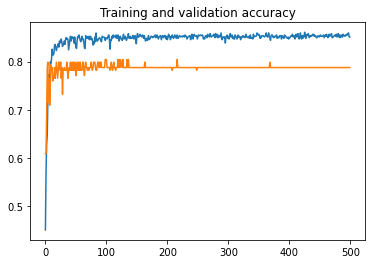

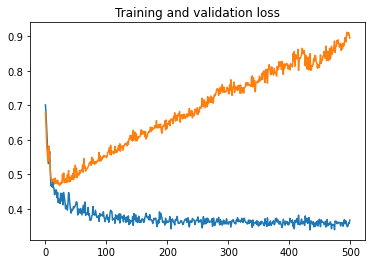

In [34]:
# 에포크에 따른 모델의 변화를 확인. 진동이 심하다는 걸 확인할 수 있다. 
# 파란색이 훈련 데이터, 노란색이 검증 데이터에 대한 정확도, 손실 그래프다

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# 훈련 데이터, 검증 데이터에 대한 에포크당 정확도
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# 훈련 데이터, 검증 데이터에 대한 에포크당 손실률
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )



손실 부분에서 진동이 계속 일어났다.

# 5. 예측하기
<br>
가장 훈련이 잘된 모델로 값을 예측해보자

In [35]:
model.load_weights(filename)
prediction = np.where(model.predict(x_test) > 0.5, 1, 0) # 생존 여부(생존 : 1, 사망 : 0)를 확인해야하기 때문에 예측값이 0.5를 넘기면 1, 아니면 0으로 했다. 

In [36]:
prediction.reshape(418)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## csv파일 생성
<br>
에측값과 앞서 저장한 승객 번호를 submission 파일 생성에 사용한다. 

In [37]:
predict_toCsv = {"PassengerId": test_PassengerId, "Survived": prediction}

In [38]:
#csv파일 생성
submission = pd.DataFrame()

submission['PassengerId'] = 0
submission['Survived'] = 0

submission['PassengerId'] = predict_toCsv["PassengerId"]
submission['Survived'] = predict_toCsv["Survived"]

In [39]:
submission.to_csv('submission.csv', index=False) # 파일 저장